In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from aesara import tensor as at
from bokeh.io import output_notebook, show
# from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
import pysindy as ps
from pydmd import DMD


In [2]:
def get_trajectory_matrix(trend):
    return np.array([trend[0]['trends']['node_count'][i] for i in range(3)])

In [3]:
# Network topology
N_pop = 200
g = nx.erdos_renyi_graph(N_pop, .3)
N_sim = 100
# 2° Model selection
models = [ep.SIRModel(g) for i in range(N_sim)]

# 2° Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.01)
cfg.add_model_parameter('gamma', 0.02)
cfg.add_model_parameter("fraction_infected", 0.1)
[model.set_initial_status(cfg) for model in models]
Nt = 200
trends = []
X = np.zeros((N_sim, 3, Nt))
for i, model in enumerate(models):
    iteration = model.iteration_bunch(Nt)
    
    trends.append(model.build_trends(iteration))
    X[i, :, :] = get_trajectory_matrix(trends[-1])
# 2° Simulation execution




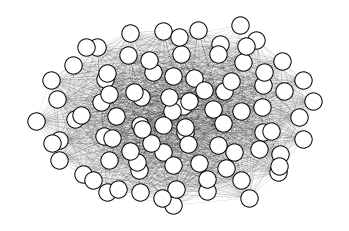

In [4]:
fig, ax = plt.subplots(1)
N_pops = [50, 40]
p_Is = [1.0, .3]
for N, p in zip(N_pops, p_Is):
    illustration_model = nx.erdos_renyi_graph(N, p)
    nx.draw(illustration_model, ax=ax,  width=.1, style='dashed', edge_color='k', node_color='w', edgecolors='k')
    fig.savefig("Erdos_Renyi_Illustration_{pop}_{pER}.svg".format(pop=N, pER=p), format='svg')

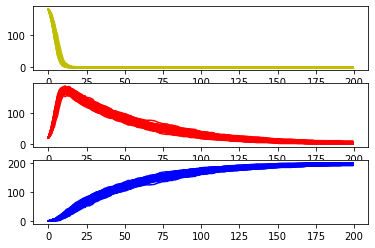

In [5]:
fig, ax = plt.subplots(3)
for traj in X:
    ax[0].plot(traj[0,:], color='y')
    ax[1].plot(traj[1,:], color='r')
    ax[2].plot(traj[2,:], color='b')
plt.show()

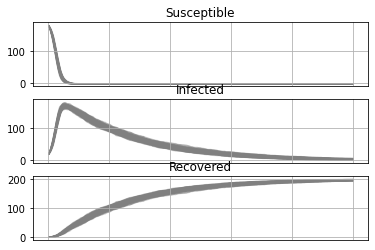

In [6]:
x_grouped = [X[:,i,:] for i in range(3)]
fig, ax = plt.subplots(3)

for ci in np.arange(95, 10, -5):
    for (i, x) in enumerate(x_grouped):
        low = np.percentile(x, 50 - ci / 2, axis=0)
        high = np.percentile(x, 50 + ci / 2, axis=0)
        ax[i].fill_between(np.linspace(0,1,x.shape[1]), low, high, color='gray', alpha= np.exp(-.01*ci))
ax[0].set_title("Susceptible")
ax[1].set_title("Infected")
ax[2].set_title("Recovered")
_ = [x.grid() for x in ax]
_ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
_ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
plt.show()

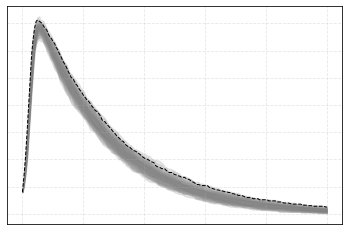

In [7]:
fig, ax = plt.subplots(1)
x = x_grouped[1]
for ci in np.arange(95, 10, -5):
    low = np.percentile(x, 50 - ci / 2, axis=0)
    high = np.percentile(x, 50 + ci / 2, axis=0)
    if ci == 85:
        ax.plot(np.linspace(0,1,x.shape[1]), high, color='k', linestyle='dashed', linewidth=1)
    ax.fill_between(np.linspace(0,1,x.shape[1]), low, high, color='gray', alpha= .3*(1.0-np.exp(-.01*ci)))
ax.grid(linestyle='dashed', alpha=.3)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
fig.savefig('Deviation_Trajectory_Illustration.svg', format='svg')

In [8]:
t = [*list(range(Nt))]*N_sim
x_grouped[0].shape

(100, 200)

In [9]:
X_list = [x.T for x in X]
# for i in range(3):
#     X_2D[i,:] = np.array([X[j,i,:] for j in range(N_sim)]).T.ravel()
# t = np.hstack([np.repeat(i, N_sim) for i in range(Nt)])
X_list[0][:,2]

array([  0.,   0.,   1.,   7.,   7.,   7.,   8.,  10.,  15.,  15.,  19.,
        24.,  29.,  29.,  34.,  35.,  38.,  43.,  47.,  53.,  55.,  58.,
        65.,  67.,  71.,  72.,  73.,  75.,  78.,  78.,  80.,  84.,  86.,
        88.,  90.,  93.,  97., 102., 105., 105., 108., 112., 112., 114.,
       117., 118., 121., 121., 121., 127., 127., 127., 128., 130., 130.,
       132., 132., 138., 138., 139., 139., 141., 145., 146., 148., 149.,
       149., 150., 151., 153., 155., 158., 159., 161., 161., 162., 162.,
       162., 162., 162., 162., 163., 163., 164., 165., 166., 167., 167.,
       167., 167., 167., 167., 168., 169., 170., 170., 172., 172., 172.,
       172., 172., 173., 173., 173., 175., 175., 176., 177., 178., 178.,
       178., 179., 179., 179., 179., 180., 180., 181., 182., 182., 184.,
       185., 185., 186., 186., 186., 186., 186., 187., 188., 189., 189.,
       189., 189., 189., 190., 191., 191., 191., 191., 191., 192., 192.,
       192., 192., 192., 192., 192., 192., 193., 19

In [10]:
from Quantile_STLSQ import Quantile_STLSQ
reg_model = ps.SINDy(Quantile_STLSQ(Nt,tau=.5, threshold=1e-2, alpha=.5))

reg_model.fit(X_list, t=np.linspace(0,1,Nt), multiple_trajectories=True)
reg_model.print()

Quantile_STLSQ initialized


RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 0 (i0) has mismatching shape. Got 20000-by-10. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 200-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

200

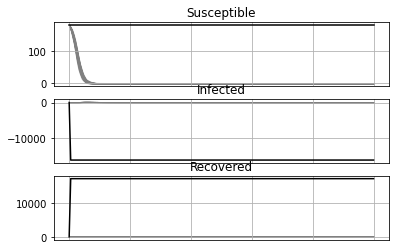

In [ ]:



x_grouped = [X[:,i,:] for i in range(3)]
fig, ax = plt.subplots(3)
t = np.linspace(0,1,x_grouped[0].shape[1])
sim = reg_model.simulate(x0=X_list[0][0,:], t=np.linspace(0,200, t.shape[0]))

for ci in np.arange(95, 10, -5):
    for (i, x) in enumerate(x_grouped):
        low = np.percentile(x, 50 - ci / 2, axis=0)
        high = np.percentile(x, 50 + ci / 2, axis=0)
        ax[i].fill_between(t, low, high, color='gray', alpha= np.exp(-.01*ci))
ax[0].plot(t,sim[:,0], color='k')
ax[1].plot(t, sim[:,1], color='k')
ax[2].plot(t, sim[:,2], color='k')

ax[0].set_title("Susceptible")
ax[1].set_title("Infected")
ax[2].set_title("Recovered")
_ = [x.grid() for x in ax]
_ = [x.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
_ = [x.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False) for x in ax]
plt.show()

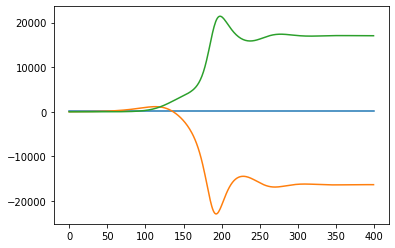

In [ ]:
sim = reg_model.simulate(x0=X_list[0][0,:], t=np.linspace(0,.2, 400))
plt.plot(sim)